# VGG16

## 필요 라이브러리 불러오기

In [ ]:
import timeit
import io
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model
from keras import models
from keras import layers


Using TensorFlow backend.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import tensorflow as tf


np.random.seed(3)
tf.random.set_seed(3)

## 데이터 구성 현황
- 손상 컨테이너: 대각면 각도 사진만 추출 - 배경 있는 것, 없는 것 혼합 (2272장)
- 정상 컨테이너: 대각면 각도 사진만 추출 - 배경 있는 것, 없는 것 혼합 (2232장)
- 손상 사진 비율: 50.44%, 정상 사진 비율: 49.56%  
- Input데이터 사이즈 : (224 * 224 * 3)  

## 전이학습 시작하기 (VGG)

In [ ]:
X = np.load('./211025_vgg_input.npy')
Y = np.load('./211025_vgg_target.npy')

In [ ]:
print("인풋 세트의 배열형태: ", X.shape)
print("타겟 세트의 배열형태: ", Y.shape)

인풋 세트의 배열형태:  (4504, 224, 224, 3)
타겟 세트의 배열형태:  (4504,)


In [ ]:
x = np.unique(Y, return_counts=True)
damage_class = int(x[0][0])
normal_class = int(x[0][1])

damage_count = int(x[1][0])
normal_count = int(x[1][1])

print("손상 컨테이너: {}장".format(damage_count))
print("정상 컨테이너: {}장".format(normal_count))

total = damage_count + normal_count
d_ratio = damage_count/total*100
n_ratio = normal_count/total*100

print("손상 사진 비율: {0:.2f}%, 정상 사진 비율: {1:.2f}%".format(d_ratio, n_ratio))

손상 컨테이너: 2272장
정상 컨테이너: 2232장
손상 사진 비율: 50.44%, 정상 사진 비율: 49.56%


In [ ]:
print(X.shape)
print(Y.shape)

(4504, 224, 224, 3)
(4504,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state=42)

In [ ]:
# 255로 나눠주어 전처리 시작
my_resize = 224
X_train = X_train.reshape(X_train.shape[0], my_resize, my_resize, 3).astype('float32')/255
X_test = X_test.reshape(X_test.shape[0], my_resize, my_resize, 3).astype('float32')/255
print("훈련 세트 배열: ", X_train.shape)
print("테스트 세트 배열: ", X_test.shape)

훈련 세트 배열:  (3603, 224, 224, 3)
테스트 세트 배열:  (901, 224, 224, 3)


## AlexNet 구조  

### 사전 훈련된 VGG-16 컨벌루션 신경망 불러오기  

*   사전 훈련된 VGG-16 신경망을 vgg16을 사용하여 불러옵니다.  
  
### Input layer  

*   Input image : 224x224x3

*   Conv2D : block을 5개로 나누어 컨벌루션층을 2~3개로 쌓은후 필터커널로 특성맵을 컨볼루션
  
*   MaxPooling :  2x2 최대 풀링을  stride=2 로 적용하여 특성맵 사이즈 줄임


### Fully connected layer  


*   불러온 vgg-16 컨벌루션 신경망에 Fully connected layer만 임의로 파라미터 설정  
*   7 x 7 x 512의 특성맵을 flatten 
*   fc1층의 뉴런을 fully connected, fc2는 fc1층의 뉴런과 fully connected
*   각 층 훈련시 dropout이 적용

In [ ]:
from keras.applications import vgg16
conv_layers = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.summary() 

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
for layer in conv_layers.layers:
    layer.trainable = False # 프리징

model = models.Sequential()

model.add(conv_layers)

model.add(layers.Flatten())  # VGG16 뒤에 붙임, 여기서부터 새로 학습됨 
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()



vgg16_model_path = 'vgg16_tl.h5'

model.save(vgg16_model_path)  


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

In [ ]:
from keras.models import load_model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import tensorflow as tf
from tensorflow.keras import optimizers
np.random.seed(3)
tf.random.set_seed(3)

In [ ]:
model = load_model(vgg16_model_path)

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['acc'])

## 딥러닝 실시

*   ModelCheckpoint로 hdf5파일에 최선의 데이터 저장(최소 val_loss)  
*   patience 설정후 EarlyStopping사용하여 조기종료(patience=10 일 경우 epoch가 10번 돌아가는동안 개선되지 않는다면 조기종료)  
*   AlexNet architecture 를 그대로 사용하여 딥러닝 후 교차검증 시행


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime, os
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/vgg16.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)


In [ ]:
# 모델의 실행
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                    epochs=50, batch_size=128, verbose=1, 
                    callbacks=[early_stopping_callback,checkpointer])

Epoch 1/50
29/29 [==============================] - 28s 484ms/step - loss: 1.1241 - acc: 0.5525 - val_loss: 0.5977 - val_acc: 0.7880

Epoch 00001: val_loss improved from inf to 0.59770, saving model to ./model\vgg16.hdf5
Epoch 2/50
29/29 [==============================] - 10s 342ms/step - loss: 0.5636 - acc: 0.7167 - val_loss: 0.3642 - val_acc: 0.8368

Epoch 00002: val_loss improved from 0.59770 to 0.36420, saving model to ./model\vgg16.hdf5
Epoch 3/50
29/29 [==============================] - 10s 341ms/step - loss: 0.3620 - acc: 0.8284 - val_loss: 0.1760 - val_acc: 0.9401

Epoch 00003: val_loss improved from 0.36420 to 0.17598, saving model to ./model\vgg16.hdf5
Epoch 4/50
29/29 [==============================] - 10s 342ms/step - loss: 0.2058 - acc: 0.9145 - val_loss: 0.1122 - val_acc: 0.9634

Epoch 00004: val_loss improved from 0.17598 to 0.11224, saving model to ./model\vgg16.hdf5
Epoch 5/50
29/29 [==============================] - 10s 341ms/step - loss: 0.1082 - acc: 0.9612 - val_lo

## 결과 출력

###  종료된 마지막 epoch기준 결과출력 

In [ ]:
# 테스트 세트에 적용
# 마지막 epoch 기준
print('\n Test Accurary: %.4f' % (model.evaluate(X_test, Y_test)[1]))

29/29 [==============================] - 6s 69ms/step - loss: 0.0535 - acc: 0.9834

 Test Accurary: 0.9834


### hdf5에 저장된 최선의 결과 출력

In [ ]:
from tensorflow.keras.models import load_model
model2 = load_model('./model/vgg16.hdf5')

In [ ]:
# 테스트 세트에 적용
# 마지막 epoch 기준
print('\n Test Accurary: %.4f' % (model2.evaluate(X_test, Y_test)[1]))

29/29 [==============================] - 2s 69ms/step - loss: 0.0244 - acc: 0.9911

 Test Accurary: 0.9911


## 검증 세트와 학습 세트간 손실값 오차 그래프

In [ ]:
y_vloss = history.history['val_loss']  # 검증 세트의 오차
y_loss = history.history['loss']  #  학습 세트의 오차

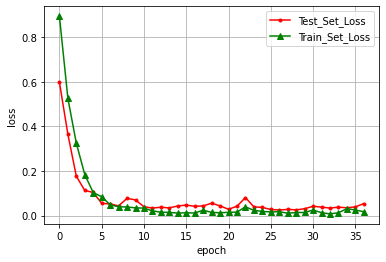

In [ ]:
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Test_Set_Loss')
plt.plot(x_len, y_loss, marker='^', c='green', label='Train_Set_Loss')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()